In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
folder = './Gender/'
files = sorted(os.listdir(folder))

In [3]:
files

['01Amman_PM10_Male.xlsx',
 '02Amman_PM10_Female.xlsx',
 '03Amman_NO2_Male.xlsx',
 '04Amman_NO2_Female.xlsx',
 '05Amman_SO2_Male.xlsx',
 '06Amman_SO2_Female.xlsx',
 '07Irbid_PM10_Male.xlsx',
 '08Irbid_PM10_Female.xlsx',
 '09Irbid_NO2_Male.xlsx',
 '10Irbid_NO2_Female.xlsx',
 '11Irbid_SO2_Male.xlsx',
 '12Irbid_SO2_Female.xlsx',
 '13Zarqa_PM10_Male.xlsx',
 '14Zarqa_PM10_Female.xlsx',
 '15Zarqa_NO2_Male.xlsx',
 '16Zarqa_NO2_Female.xlsx',
 '17Zarqa_SO2_Male.xlsx',
 '18Zarqa_SO2_Female.xlsx']

Gender Commulative

C:\Users\user\AppData\Local\Temp\ipykernel_11188\1829382988.py:200: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


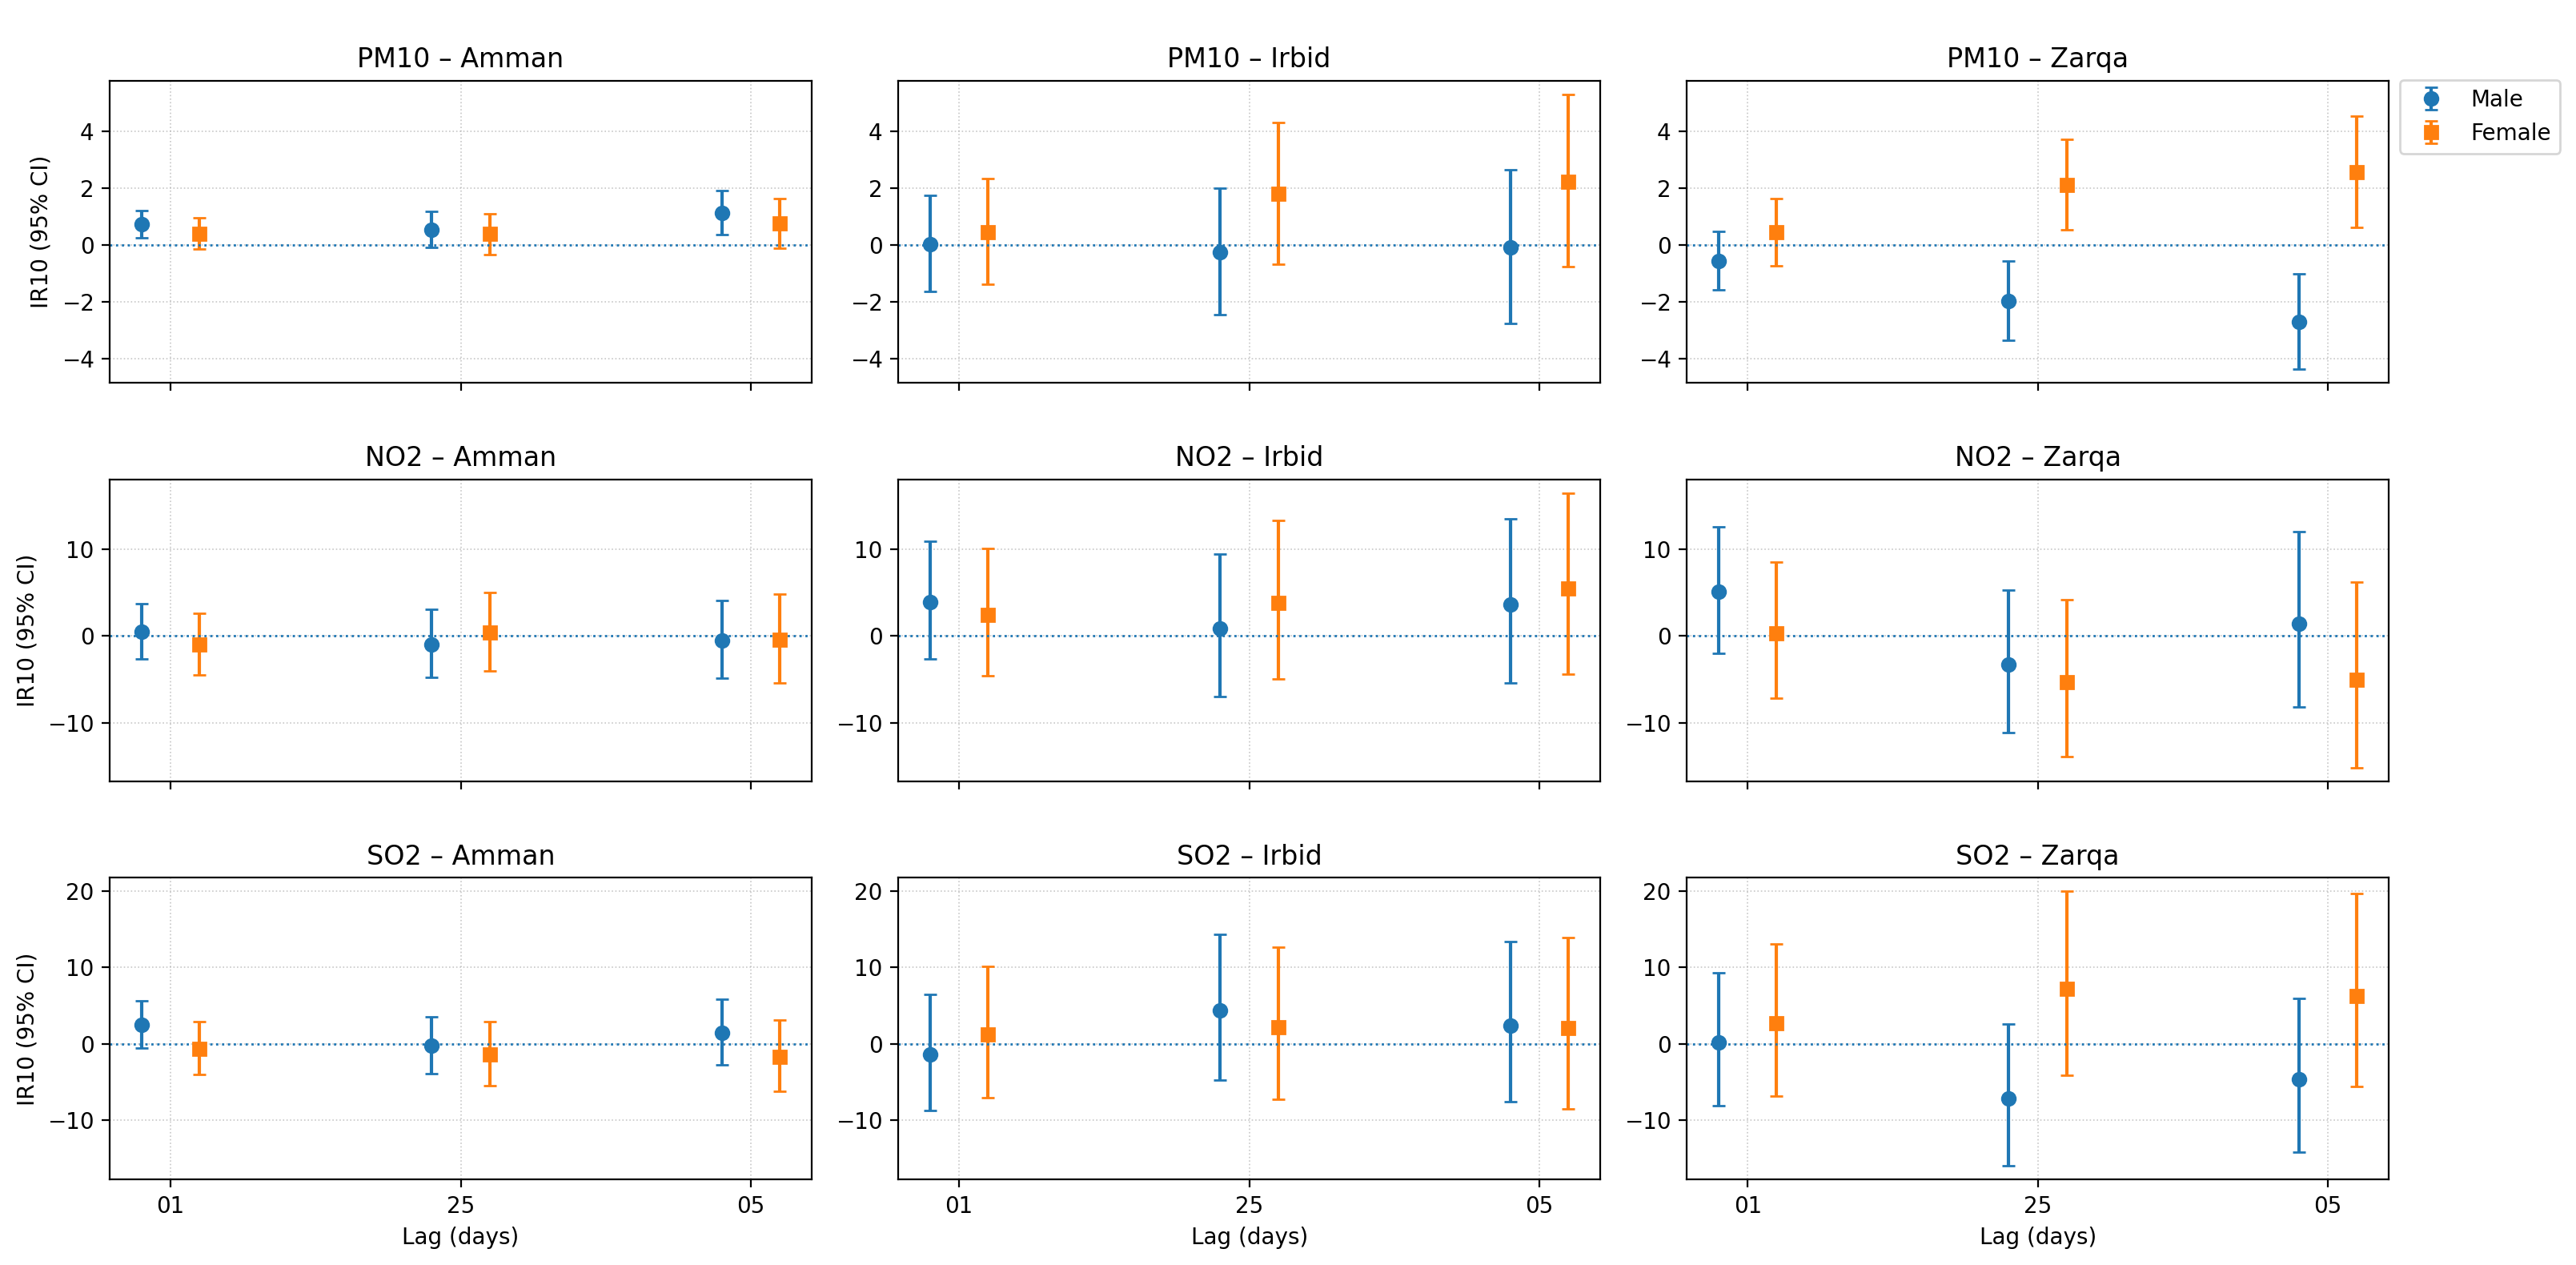

In [17]:
# ---------- Config ----------
BASE_DIR = "./Gender/"  # change to "." if running locally
LAGS_LABELS = ['0','1','2','3','4','5','6','01','25','05']
N = len(LAGS_LABELS)
X = np.arange(N)

# File mapping: (City, Pollutant) -> {"Male": path, "Female": path}
files_map = {
    # Amman
    ("Amman", "PM10"): {
        "Male":   os.path.join(BASE_DIR, "01Amman_PM10_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "02Amman_PM10_Female.xlsx"),
    },
    ("Amman", "NO2"): {
        "Male":   os.path.join(BASE_DIR, "03Amman_NO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "04Amman_NO2_Female.xlsx"),
    },
    ("Amman", "SO2"): {
        "Male":   os.path.join(BASE_DIR, "05Amman_SO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "06Amman_SO2_Female.xlsx"),
    },
    # Irbid
    ("Irbid", "PM10"): {
        "Male":   os.path.join(BASE_DIR, "07Irbid_PM10_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "08Irbid_PM10_Female.xlsx"),
    },
    ("Irbid", "NO2"): {
        "Male":   os.path.join(BASE_DIR, "09Irbid_NO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "10Irbid_NO2_Female.xlsx"),
    },
    ("Irbid", "SO2"): {
        "Male":   os.path.join(BASE_DIR, "11Irbid_SO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "12Irbid_SO2_Female.xlsx"),
    },
    # Zarqa
    ("Zarqa", "PM10"): {
        "Male":   os.path.join(BASE_DIR, "13Zarqa_PM10_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "14Zarqa_PM10_Female.xlsx"),
    },
    ("Zarqa", "NO2"): {
        "Male":   os.path.join(BASE_DIR, "15Zarqa_NO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "16Zarqa_NO2_Female.xlsx"),
    },
    ("Zarqa", "SO2"): {
        "Male":   os.path.join(BASE_DIR, "17Zarqa_SO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "18Zarqa_SO2_Female.xlsx"),
    },
}

# TRANSPOSED layout:
row_order = ["PM10", "NO2", "SO2"]            # rows = pollutants
col_order = ["Amman", "Irbid", "Zarqa"]       # cols = cities

# ---------- Data loader with tail override (01,25,05) ----------
def load_ir_ci_series(path):
    """
    Expect columns: IR10, inf10, sup10.
    RULE (as requested): the **last three rows** in every file are the lags
    '01', '25', '05' in this exact order; we force these positions accordingly,
    regardless of any lag column content.

    For the first 7 lags ('0'..'6'), we try to use a 'lag'/'lags' column if present.
    If not, we take the first 7 rows in order as lags 0..6.
    Returns y (10,), yerr (2,10) aligned with LAGS_LABELS.
    """
    df = pd.read_excel(path).reset_index(drop=True)
    cols = {c.lower(): c for c in df.columns}

    IR = cols.get("ir10")
    LO = cols.get("inf10")
    HI = cols.get("sup10")
    if IR is None or LO is None or HI is None:
        raise ValueError(f"{os.path.basename(path)} must contain IR10, inf10, sup10 columns.")

    # Initialize arrays
    y = np.full(N, np.nan, dtype=float)
    yerr_low = np.full(N, np.nan, dtype=float)
    yerr_high = np.full(N, np.nan, dtype=float)

    # ----- Handle last three lags strictly from the last 3 rows -----
    if len(df) < 3:
        raise ValueError(f"{os.path.basename(path)} has fewer than 3 rows; cannot assign tail lags 01,25,05.")
    tail = df.tail(3).reset_index(drop=True)
    # Order is guaranteed: row0->'01', row1->'25', row2->'05'
    tail_labels = ['01', '25', '05']
    for k, lbl in enumerate(tail_labels):
        idx = LAGS_LABELS.index(lbl)
        val = float(tail.loc[k, IR])
        lo  = float(tail.loc[k, LO])
        hi  = float(tail.loc[k, HI])
        y[idx] = val
        yerr_low[idx]  = abs(val - lo)
        yerr_high[idx] = abs(hi - val)

    # ----- Handle the first seven lags: '0'..'6' -----
    head = df.iloc[:max(0, len(df) - 3)].copy()  # everything except the last 3 rows
    lag_col = None
    for key in ["lag", "lags", "day", "index"]:
        if key in cols:
            lag_col = cols[key]
            break

    if lag_col is not None:
        # Map by lag values if available
        # Normalize to strings and keep only 0..6
        head["_lag_key"] = head[lag_col].astype(str).str.strip()
        # Accept 0..6 as either '0','1',... or numeric 0..6
        for intlag in range(7):
            lbl = str(intlag)
            # try to match exactly
            sel = head[head["_lag_key"] == lbl]
            if sel.empty:
                # also try numeric equivalence (e.g., '0.0')
                try:
                    sel = head[np.isclose(head[lag_col].astype(float), float(intlag), equal_nan=False)]
                except Exception:
                    sel = pd.DataFrame()
            if not sel.empty:
                row = sel.iloc[0]
                idx = LAGS_LABELS.index(lbl)
                val = float(row[IR]); lo = float(row[LO]); hi = float(row[HI])
                y[idx] = val
                yerr_low[idx]  = abs(val - lo)
                yerr_high[idx] = abs(hi - val)
    else:
        # No lag column: assume first 7 rows correspond to lags 0..6 in order
        if len(head) < 7:
            # pad with NaNs if fewer than 7 rows
            needed = 7 - len(head)
            head = pd.concat([head, pd.DataFrame([{IR: np.nan, LO: np.nan, HI: np.nan}] * needed)], ignore_index=True)
        for intlag in range(7):
            row = head.iloc[intlag]
            idx = LAGS_LABELS.index(str(intlag))
            val = float(row[IR]) if pd.notna(row[IR]) else np.nan
            lo  = float(row[LO]) if pd.notna(row[LO]) else np.nan
            hi  = float(row[HI]) if pd.notna(row[HI]) else np.nan
            y[idx] = val
            yerr_low[idx]  = abs(val - lo) if np.all(pd.notna([val, lo])) else np.nan
            yerr_high[idx] = abs(hi - val) if np.all(pd.notna([val, hi])) else np.nan

    return y, np.vstack([yerr_low, yerr_high])

# ---------- Compute row-wise (pollutant-wise) y-limits ----------
def compute_row_ylim(pollutant):
    ymin, ymax = np.inf, -np.inf
    for city in col_order:
        pair = files_map[(city, pollutant)]
        for gender in ("Male", "Female"):
            y, yerr = load_ir_ci_series(pair[gender])
            lo = y - yerr[0]
            hi = y + yerr[1]
            if np.isfinite(np.nanmin(lo)):
                ymin = min(ymin, np.nanmin(lo))
            if np.isfinite(np.nanmax(hi)):
                ymax = max(ymax, np.nanmax(hi))
    if not np.isfinite(ymin) or not np.isfinite(ymax) or ymin == ymax:
        ymin, ymax = 0.9, 1.1
    pad = 0.05 * (ymax - ymin)
    return ymin - pad, ymax + pad

row_ylim = {poll: compute_row_ylim(poll) for poll in row_order}

# ---------- Plot (transposed layout) ----------
fig, axes = plt.subplots(3, 3, figsize=(16, 8), constrained_layout=True, sharex=True, dpi=200)
for i, pollutant in enumerate(row_order):      # rows = pollutants
    for j, city in enumerate(col_order):       # cols = cities
        ax = axes[i, j]
        pair = files_map[(city, pollutant)]

        # Male
        y_m, yerr_m = load_ir_ci_series(pair["Male"])
        ax.errorbar(X[7:] - 0.1, y_m[7:], yerr=yerr_m[:, 7:], fmt='o', capsize=3, label='Male')

        # Female
        y_f, yerr_f = load_ir_ci_series(pair["Female"])
        ax.errorbar(X[7:] + 0.1, y_f[7:], yerr=yerr_f[:, 7:], fmt='s', capsize=3, label='Female')

        # Titles & axes
        ax.set_title('\n' + f"{pollutant} – {city}")
        ax.set_xticks(X[7:])
        ax.set_xticklabels(LAGS_LABELS[7:])
        if j == 0:
            ax.set_ylabel("IR10 (95% CI)")
        if i == len(row_order) - 1:
            ax.set_xlabel("Lag (days)")

        # Row-wise y-axis (same for a given pollutant across cities)
        ax.set_ylim(row_ylim[pollutant])

        # Reference line
        ax.axhline(0, linestyle=":", linewidth=1)

        # Grid and legend
        ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
        if i == 0 and j == 2:
            ax.legend(bbox_to_anchor=(-1.74, -1.96, 3, 3))

#plt.suptitle("IR10 with 95% CI by Pollutant (rows) and City (columns) — Male vs Female", y=1.02, fontsize=14)
#plt.savefig("errorbars_3x3_transposed.png", dpi=300)
plt.tight_layout()
plt.show()


Gender Single

C:\Users\user\AppData\Local\Temp\ipykernel_11188\4188337631.py:200: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


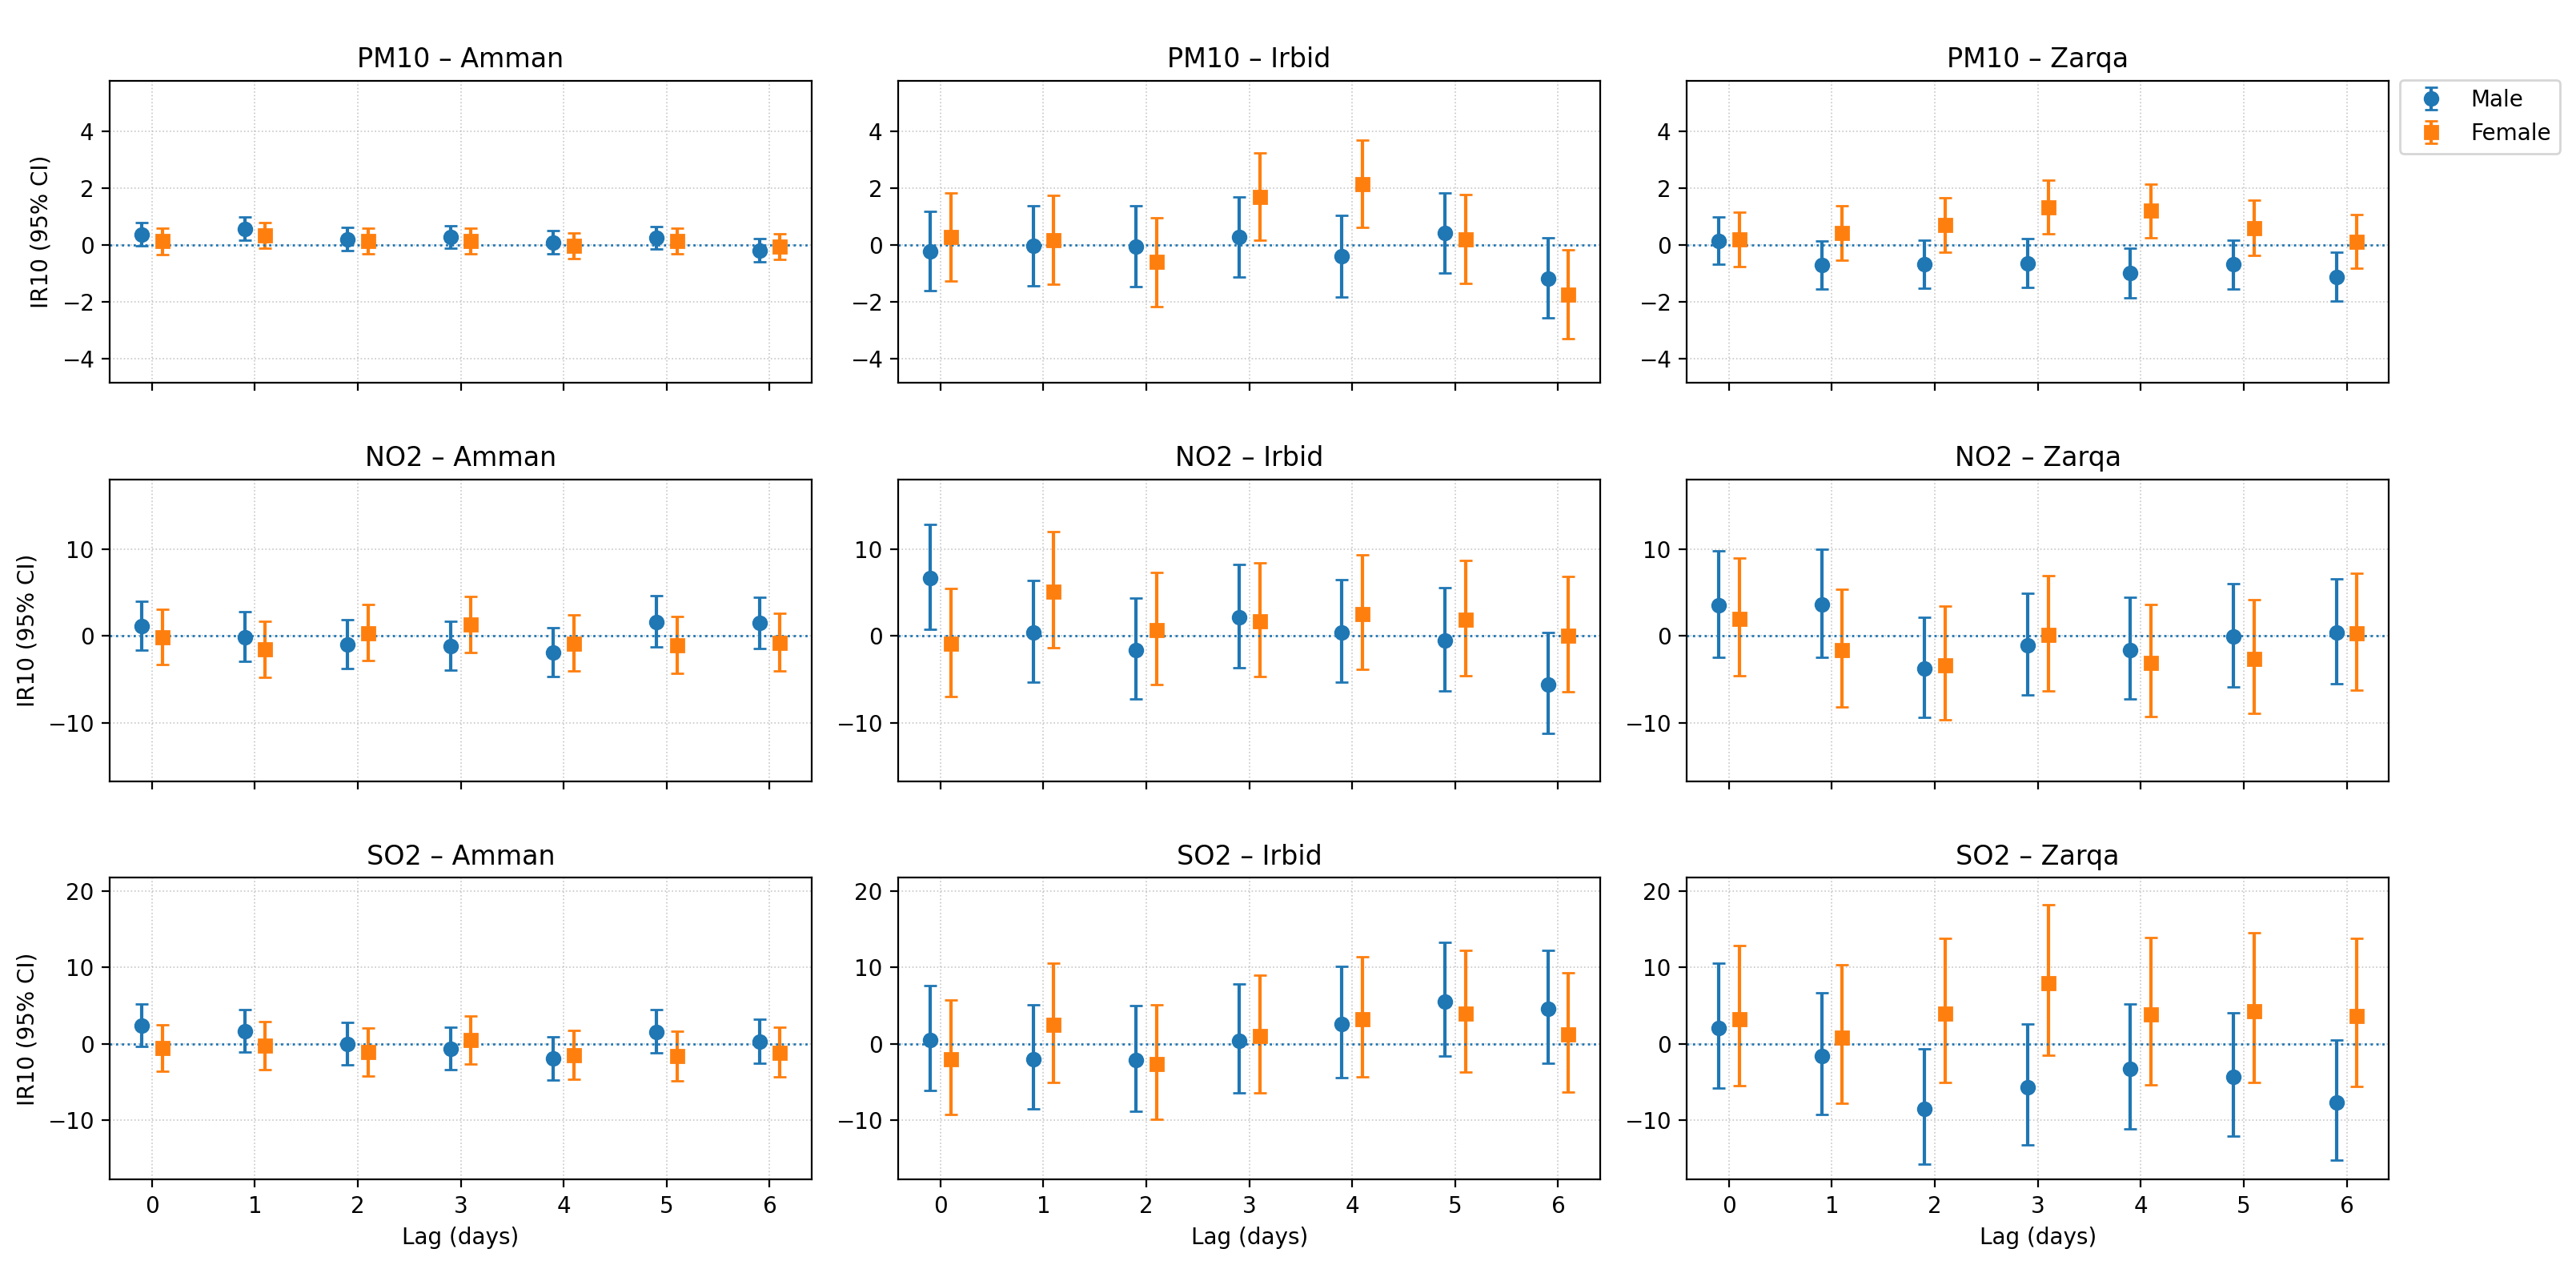

In [15]:
# ---------- Config ----------
BASE_DIR = "./Gender/"  # change to "." if running locally
LAGS_LABELS = ['0','1','2','3','4','5','6','01','25','05']
N = len(LAGS_LABELS)
X = np.arange(N)

# File mapping: (City, Pollutant) -> {"Male": path, "Female": path}
files_map = {
    # Amman
    ("Amman", "PM10"): {
        "Male":   os.path.join(BASE_DIR, "01Amman_PM10_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "02Amman_PM10_Female.xlsx"),
    },
    ("Amman", "NO2"): {
        "Male":   os.path.join(BASE_DIR, "03Amman_NO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "04Amman_NO2_Female.xlsx"),
    },
    ("Amman", "SO2"): {
        "Male":   os.path.join(BASE_DIR, "05Amman_SO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "06Amman_SO2_Female.xlsx"),
    },
    # Irbid
    ("Irbid", "PM10"): {
        "Male":   os.path.join(BASE_DIR, "07Irbid_PM10_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "08Irbid_PM10_Female.xlsx"),
    },
    ("Irbid", "NO2"): {
        "Male":   os.path.join(BASE_DIR, "09Irbid_NO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "10Irbid_NO2_Female.xlsx"),
    },
    ("Irbid", "SO2"): {
        "Male":   os.path.join(BASE_DIR, "11Irbid_SO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "12Irbid_SO2_Female.xlsx"),
    },
    # Zarqa
    ("Zarqa", "PM10"): {
        "Male":   os.path.join(BASE_DIR, "13Zarqa_PM10_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "14Zarqa_PM10_Female.xlsx"),
    },
    ("Zarqa", "NO2"): {
        "Male":   os.path.join(BASE_DIR, "15Zarqa_NO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "16Zarqa_NO2_Female.xlsx"),
    },
    ("Zarqa", "SO2"): {
        "Male":   os.path.join(BASE_DIR, "17Zarqa_SO2_Male.xlsx"),
        "Female": os.path.join(BASE_DIR, "18Zarqa_SO2_Female.xlsx"),
    },
}

# TRANSPOSED layout:
row_order = ["PM10", "NO2", "SO2"]            # rows = pollutants
col_order = ["Amman", "Irbid", "Zarqa"]       # cols = cities

# ---------- Data loader with tail override (01,25,05) ----------
def load_ir_ci_series(path):
    """
    Expect columns: IR10, inf10, sup10.
    RULE (as requested): the **last three rows** in every file are the lags
    '01', '25', '05' in this exact order; we force these positions accordingly,
    regardless of any lag column content.

    For the first 7 lags ('0'..'6'), we try to use a 'lag'/'lags' column if present.
    If not, we take the first 7 rows in order as lags 0..6.
    Returns y (10,), yerr (2,10) aligned with LAGS_LABELS.
    """
    df = pd.read_excel(path).reset_index(drop=True)
    cols = {c.lower(): c for c in df.columns}

    IR = cols.get("ir10")
    LO = cols.get("inf10")
    HI = cols.get("sup10")
    if IR is None or LO is None or HI is None:
        raise ValueError(f"{os.path.basename(path)} must contain IR10, inf10, sup10 columns.")

    # Initialize arrays
    y = np.full(N, np.nan, dtype=float)
    yerr_low = np.full(N, np.nan, dtype=float)
    yerr_high = np.full(N, np.nan, dtype=float)

    # ----- Handle last three lags strictly from the last 3 rows -----
    if len(df) < 3:
        raise ValueError(f"{os.path.basename(path)} has fewer than 3 rows; cannot assign tail lags 01,25,05.")
    tail = df.tail(3).reset_index(drop=True)
    # Order is guaranteed: row0->'01', row1->'25', row2->'05'
    tail_labels = ['01', '25', '05']
    for k, lbl in enumerate(tail_labels):
        idx = LAGS_LABELS.index(lbl)
        val = float(tail.loc[k, IR])
        lo  = float(tail.loc[k, LO])
        hi  = float(tail.loc[k, HI])
        y[idx] = val
        yerr_low[idx]  = abs(val - lo)
        yerr_high[idx] = abs(hi - val)

    # ----- Handle the first seven lags: '0'..'6' -----
    head = df.iloc[:max(0, len(df) - 3)].copy()  # everything except the last 3 rows
    lag_col = None
    for key in ["lag", "lags", "day", "index"]:
        if key in cols:
            lag_col = cols[key]
            break

    if lag_col is not None:
        # Map by lag values if available
        # Normalize to strings and keep only 0..6
        head["_lag_key"] = head[lag_col].astype(str).str.strip()
        # Accept 0..6 as either '0','1',... or numeric 0..6
        for intlag in range(7):
            lbl = str(intlag)
            # try to match exactly
            sel = head[head["_lag_key"] == lbl]
            if sel.empty:
                # also try numeric equivalence (e.g., '0.0')
                try:
                    sel = head[np.isclose(head[lag_col].astype(float), float(intlag), equal_nan=False)]
                except Exception:
                    sel = pd.DataFrame()
            if not sel.empty:
                row = sel.iloc[0]
                idx = LAGS_LABELS.index(lbl)
                val = float(row[IR]); lo = float(row[LO]); hi = float(row[HI])
                y[idx] = val
                yerr_low[idx]  = abs(val - lo)
                yerr_high[idx] = abs(hi - val)
    else:
        # No lag column: assume first 7 rows correspond to lags 0..6 in order
        if len(head) < 7:
            # pad with NaNs if fewer than 7 rows
            needed = 7 - len(head)
            head = pd.concat([head, pd.DataFrame([{IR: np.nan, LO: np.nan, HI: np.nan}] * needed)], ignore_index=True)
        for intlag in range(7):
            row = head.iloc[intlag]
            idx = LAGS_LABELS.index(str(intlag))
            val = float(row[IR]) if pd.notna(row[IR]) else np.nan
            lo  = float(row[LO]) if pd.notna(row[LO]) else np.nan
            hi  = float(row[HI]) if pd.notna(row[HI]) else np.nan
            y[idx] = val
            yerr_low[idx]  = abs(val - lo) if np.all(pd.notna([val, lo])) else np.nan
            yerr_high[idx] = abs(hi - val) if np.all(pd.notna([val, hi])) else np.nan

    return y, np.vstack([yerr_low, yerr_high])

# ---------- Compute row-wise (pollutant-wise) y-limits ----------
def compute_row_ylim(pollutant):
    ymin, ymax = np.inf, -np.inf
    for city in col_order:
        pair = files_map[(city, pollutant)]
        for gender in ("Male", "Female"):
            y, yerr = load_ir_ci_series(pair[gender])
            lo = y - yerr[0]
            hi = y + yerr[1]
            if np.isfinite(np.nanmin(lo)):
                ymin = min(ymin, np.nanmin(lo))
            if np.isfinite(np.nanmax(hi)):
                ymax = max(ymax, np.nanmax(hi))
    if not np.isfinite(ymin) or not np.isfinite(ymax) or ymin == ymax:
        ymin, ymax = 0.9, 1.1
    pad = 0.05 * (ymax - ymin)
    return ymin - pad, ymax + pad

row_ylim = {poll: compute_row_ylim(poll) for poll in row_order}

# ---------- Plot (transposed layout) ----------
fig, axes = plt.subplots(3, 3, figsize=(16, 8), constrained_layout=True, sharex=True, dpi=200)
for i, pollutant in enumerate(row_order):      # rows = pollutants
    for j, city in enumerate(col_order):       # cols = cities
        ax = axes[i, j]
        pair = files_map[(city, pollutant)]

        # Male
        y_m, yerr_m = load_ir_ci_series(pair["Male"])
        ax.errorbar(X[:7] - 0.1, y_m[:7], yerr=yerr_m[:, :7], fmt='o', capsize=3, label='Male')

        # Female
        y_f, yerr_f = load_ir_ci_series(pair["Female"])
        ax.errorbar(X[:7] + 0.1, y_f[:7], yerr=yerr_f[:, :7], fmt='s', capsize=3, label='Female')

        # Titles & axes
        ax.set_title('\n' + f"{pollutant} – {city}")
        ax.set_xticks(X[:7])
        ax.set_xticklabels(LAGS_LABELS[:7])
        if j == 0:
            ax.set_ylabel("IR10 (95% CI)")
        if i == len(row_order) - 1:
            ax.set_xlabel("Lag (days)")

        # Row-wise y-axis (same for a given pollutant across cities)
        ax.set_ylim(row_ylim[pollutant])

        # Reference line
        ax.axhline(0, linestyle=":", linewidth=1)

        # Grid and legend
        ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
        if i == 0 and j == 2:
            ax.legend(bbox_to_anchor=(-1.74, -1.96, 3, 3))

#plt.suptitle("IR10 with 95% CI by Pollutant (rows) and City (columns) — Male vs Female", y=1.02, fontsize=14)
#plt.savefig("errorbars_3x3_transposed.png", dpi=300)
plt.tight_layout()
plt.show()


In [18]:
folder = './Age/'
files = sorted(os.listdir(folder))
files

['Amman_NO2_Old.xlsx',
 'Amman_NO2_Young.xlsx',
 'Amman_PM10_Old.xlsx',
 'Amman_PM10_Young.xlsx',
 'Amman_SO2_Old.xlsx',
 'Amman_So2_Young.xlsx',
 'Irbid_NO2_Old.xlsx',
 'Irbid_NO2_Young.xlsx',
 'Irbid_PM10_Old.xlsx',
 'Irbid_PM10_Young.xlsx',
 'Irbid_SO2_Old.xlsx',
 'Irbid_SO2_Young.xlsx',
 'Zarqa_NO2_Old.xlsx',
 'Zarqa_NO2_Young.xlsx',
 'Zarqa_PM10_Old.xlsx',
 'Zarqa_PM10_Young.xlsx',
 'Zarqa_SO2_Old.xlsx',
 'Zarqa_SO2_Young.xlsx']

Age Cummulative

C:\Users\user\AppData\Local\Temp\ipykernel_11188\3420075374.py:208: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


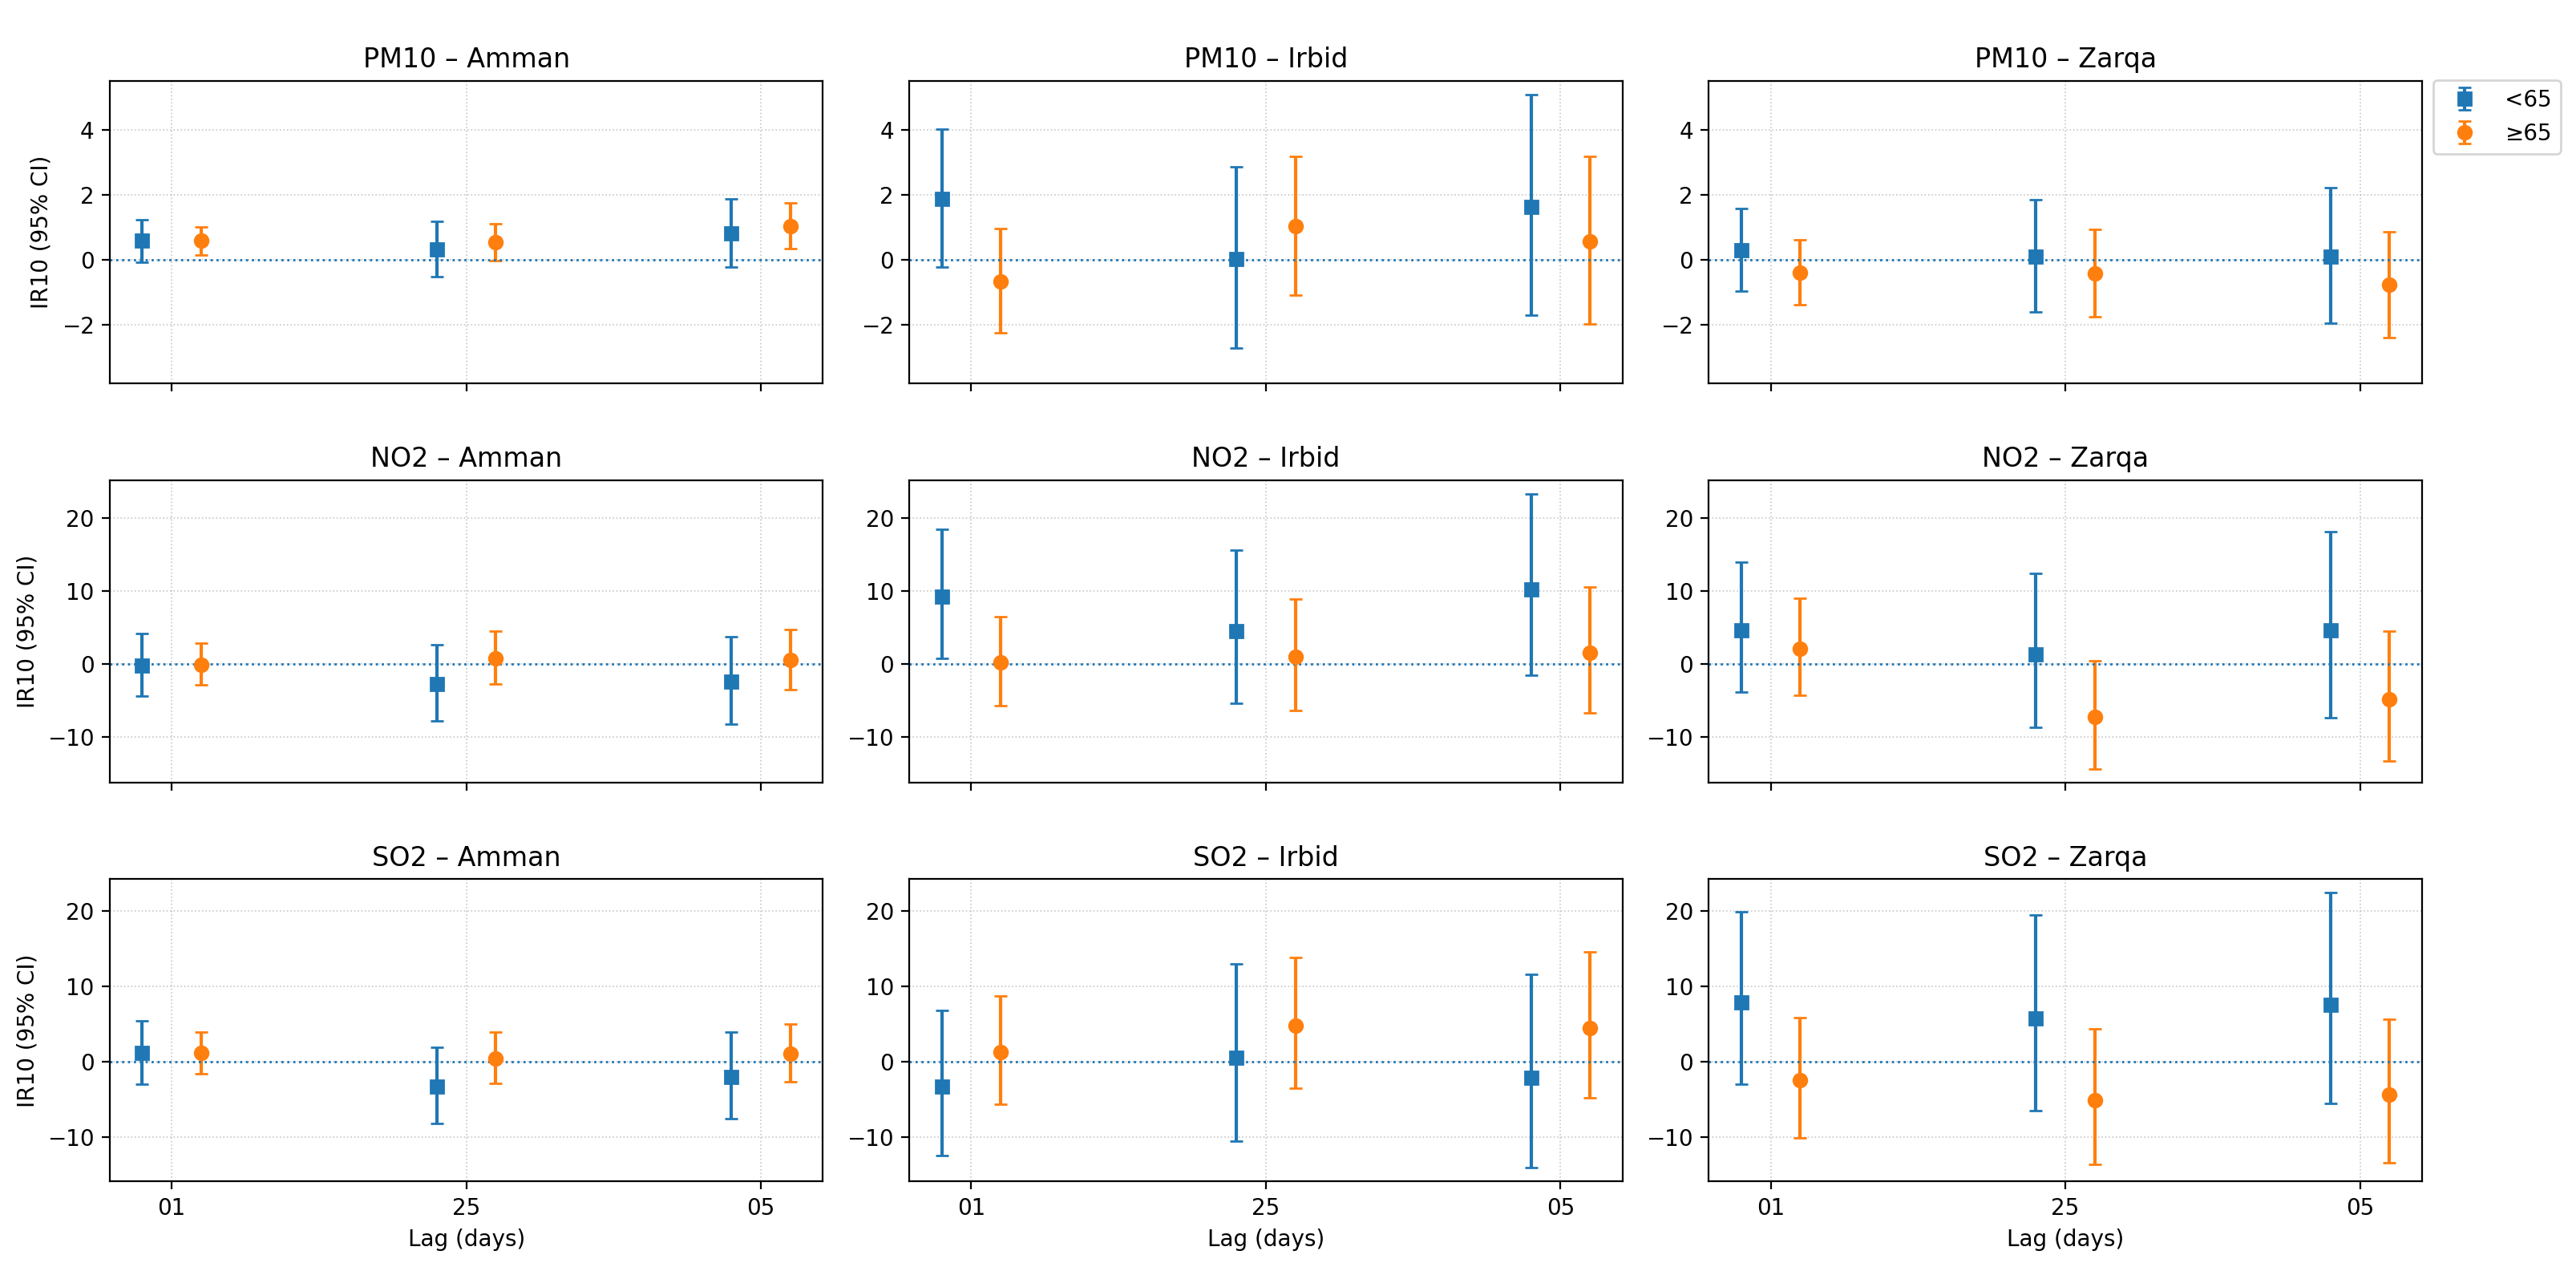

In [19]:
# Transposed 3×3 error-bar grid (rows = pollutants, cols = cities)
# - Age-stratified series: Old (>=65) vs Young (<65)
# - Center: IR10
# - 95% CI: [inf10, sup10]
# - X-axis (lags): ['0','1','2','3','4','5','6','01','25','05']
# - Each ROW (pollutant) shares the same y-axis across the three cities
# - FIX: force the last 3 points to be lags 01, 25, 05 taken from the last 3 rows (in that order)

# ---------- Config ----------
BASE_DIR = "./Age/"  # change to "." if running locally
LAGS_LABELS = ['0','1','2','3','4','5','6','01','25','05']
N = len(LAGS_LABELS)
X = np.arange(N)

# File mapping: (City, Pollutant) -> {"Old": path, "Young": path}
files_map = {
    # Amman
    ("Amman", "PM10"): {
        "Old":   os.path.join(BASE_DIR, "Amman_PM10_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Amman_PM10_Young.xlsx"),
    },
    ("Amman", "NO2"): {
        "Old":   os.path.join(BASE_DIR, "Amman_NO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Amman_NO2_Young.xlsx"),
    },
    ("Amman", "SO2"): {
        "Old":   os.path.join(BASE_DIR, "Amman_SO2_Old.xlsx"),
        # Note: provided filename has mixed case "So2"
        "Young": os.path.join(BASE_DIR, "Amman_So2_Young.xlsx"),
    },
    # Irbid
    ("Irbid", "PM10"): {
        "Old":   os.path.join(BASE_DIR, "Irbid_PM10_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Irbid_PM10_Young.xlsx"),
    },
    ("Irbid", "NO2"): {
        "Old":   os.path.join(BASE_DIR, "Irbid_NO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Irbid_NO2_Young.xlsx"),
    },
    ("Irbid", "SO2"): {
        "Old":   os.path.join(BASE_DIR, "Irbid_SO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Irbid_SO2_Young.xlsx"),
    },
    # Zarqa
    ("Zarqa", "PM10"): {
        "Old":   os.path.join(BASE_DIR, "Zarqa_PM10_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Zarqa_PM10_Young.xlsx"),
    },
    ("Zarqa", "NO2"): {
        "Old":   os.path.join(BASE_DIR, "Zarqa_NO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Zarqa_NO2_Young.xlsx"),
    },
    ("Zarqa", "SO2"): {
        "Old":   os.path.join(BASE_DIR, "Zarqa_SO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Zarqa_SO2_Young.xlsx"),
    },
}

# TRANSPOSED layout:
row_order = ["PM10", "NO2", "SO2"]            # rows = pollutants
col_order = ["Amman", "Irbid", "Zarqa"]       # cols = cities

# ---------- Data loader with tail override (01,25,05) ----------
def load_ir_ci_series(path):
    """
    Expect columns: IR10, inf10, sup10.
    RULE: the last three rows in every file are the lags '01', '25', '05' in this exact order.
    We take those three points strictly from the last three rows.
    For the first 7 lags ('0'..'6'), we try to use a 'lag'/'lags' column if present;
    otherwise we take the first 7 rows as lags 0..6 in order.

    Returns
    -------
    y : (10,) array
        Center values (IR10) aligned to LAGS_LABELS.
    yerr : (2,10) array
        Asymmetric errors [lower, upper] aligned to LAGS_LABELS.
    """
    df = pd.read_excel(path).reset_index(drop=True)
    cols = {c.lower(): c for c in df.columns}

    IR = cols.get("ir10")
    LO = cols.get("inf10")
    HI = cols.get("sup10")
    if IR is None or LO is None or HI is None:
        raise ValueError(f"{os.path.basename(path)} must contain IR10, inf10, sup10 columns.")

    y = np.full(N, np.nan, dtype=float)
    yerr_low = np.full(N, np.nan, dtype=float)
    yerr_high = np.full(N, np.nan, dtype=float)

    # ----- Last three lags from the last three rows -----
    if len(df) < 3:
        raise ValueError(f"{os.path.basename(path)} has fewer than 3 rows.")
    tail = df.tail(3).reset_index(drop=True)
    tail_labels = ['01', '25', '05']
    for k, lbl in enumerate(tail_labels):
        idx = LAGS_LABELS.index(lbl)
        val = float(tail.loc[k, IR])
        lo  = float(tail.loc[k, LO])
        hi  = float(tail.loc[k, HI])
        y[idx] = val
        yerr_low[idx]  = abs(val - lo)
        yerr_high[idx] = abs(hi - val)

    # ----- First seven lags (0..6) -----
    head = df.iloc[:max(0, len(df) - 3)].copy()
    lag_col = None
    for key in ["lag", "lags", "day", "index"]:
        if key in cols:
            lag_col = cols[key]
            break

    if lag_col is not None and not head.empty:
        head["_lag_key"] = head[lag_col].astype(str).str.strip()
        for intlag in range(7):
            lbl = str(intlag)
            sel = head[head["_lag_key"] == lbl]
            if sel.empty:
                # try numeric tolerance (e.g., 0.0)
                try:
                    sel = head[np.isclose(head[lag_col].astype(float), float(intlag), equal_nan=False)]
                except Exception:
                    sel = pd.DataFrame()
            if not sel.empty:
                row = sel.iloc[0]
                idx = LAGS_LABELS.index(lbl)
                val = float(row[IR]); lo = float(row[LO]); hi = float(row[HI])
                y[idx] = val
                yerr_low[idx]  = abs(val - lo)
                yerr_high[idx] = abs(hi - val)
    else:
        # No lag column: assume the first 7 rows correspond to 0..6
        if len(head) < 7:
            head = pd.concat([head, pd.DataFrame([{IR: np.nan, LO: np.nan, HI: np.nan}] * (7 - len(head)))],
                             ignore_index=True)
        for intlag in range(7):
            row = head.iloc[intlag]
            idx = LAGS_LABELS.index(str(intlag))
            val = float(row[IR]) if pd.notna(row[IR]) else np.nan
            lo  = float(row[LO]) if pd.notna(row[LO]) else np.nan
            hi  = float(row[HI]) if pd.notna(row[HI]) else np.nan
            y[idx] = val
            yerr_low[idx]  = abs(val - lo) if np.all(pd.notna([val, lo])) else np.nan
            yerr_high[idx] = abs(hi - val) if np.all(pd.notna([val, hi])) else np.nan

    return y, np.vstack([yerr_low, yerr_high])

# ---------- Compute row-wise (pollutant-wise) y-limits ----------
def compute_row_ylim(pollutant):
    ymin, ymax = np.inf, -np.inf
    for city in col_order:
        pair = files_map[(city, pollutant)]
        for grp in ("Old", "Young"):
            y, yerr = load_ir_ci_series(pair[grp])
            lo = y - yerr[0]
            hi = y + yerr[1]
            if np.isfinite(np.nanmin(lo)):
                ymin = min(ymin, np.nanmin(lo))
            if np.isfinite(np.nanmax(hi)):
                ymax = max(ymax, np.nanmax(hi))
    if not np.isfinite(ymin) or not np.isfinite(ymax) or ymin == ymax:
        ymin, ymax = 0.9, 1.1
    pad = 0.05 * (ymax - ymin)
    return ymin - pad, ymax + pad

row_ylim = {poll: compute_row_ylim(poll) for poll in row_order}

# ---------- Plot (transposed: rows = pollutants; columns = cities) ----------
fig, axes = plt.subplots(3, 3, figsize=(16, 8), constrained_layout=True, sharex=True, dpi=200)

for i, pollutant in enumerate(row_order):
    for j, city in enumerate(col_order):
        ax = axes[i, j]
        pair = files_map[(city, pollutant)]

        

        # Young (<65)
        y_yng, yerr_yng = load_ir_ci_series(pair["Young"])
        ax.errorbar(X[7:] - 0.1, y_yng[7:], yerr=yerr_yng[:,7:], fmt='s', capsize=3, label='<65')
        # Old (>=65)
        y_old, yerr_old = load_ir_ci_series(pair["Old"])
        ax.errorbar(X[7:] + 0.1, y_old[7:], yerr=yerr_old[:,7:], fmt='o', capsize=3, label='≥65')
        
        # Titles & axes
        ax.set_title('\n' + f"{pollutant} – {city}")
        ax.set_xticks(X[7:])
        ax.set_xticklabels(LAGS_LABELS[7:])
        if j == 0:
            ax.set_ylabel("IR10 (95% CI)")
        if i == len(row_order) - 1:
            ax.set_xlabel("Lag (days)")

        # Row-wise y-axis (same for given pollutant across all cities)
        ax.set_ylim(row_ylim[pollutant])

        # Reference line at RR=1
        ax.axhline(0, linestyle=":", linewidth=1)

        # Grid and legend
        ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
        if i == 0 and j == 2:
            ax.legend(bbox_to_anchor=(-1.79, -1.96, 3, 3))

#plt.suptitle("IR10 with 95% CI by Pollutant (rows) and City (columns) — Old vs Young", y=1.02, fontsize=14)
#plt.savefig("errorbars_3x3_transposed_age.png", dpi=300)
plt.tight_layout()
plt.show()


Age single

C:\Users\user\AppData\Local\Temp\ipykernel_11188\2726781375.py:208: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


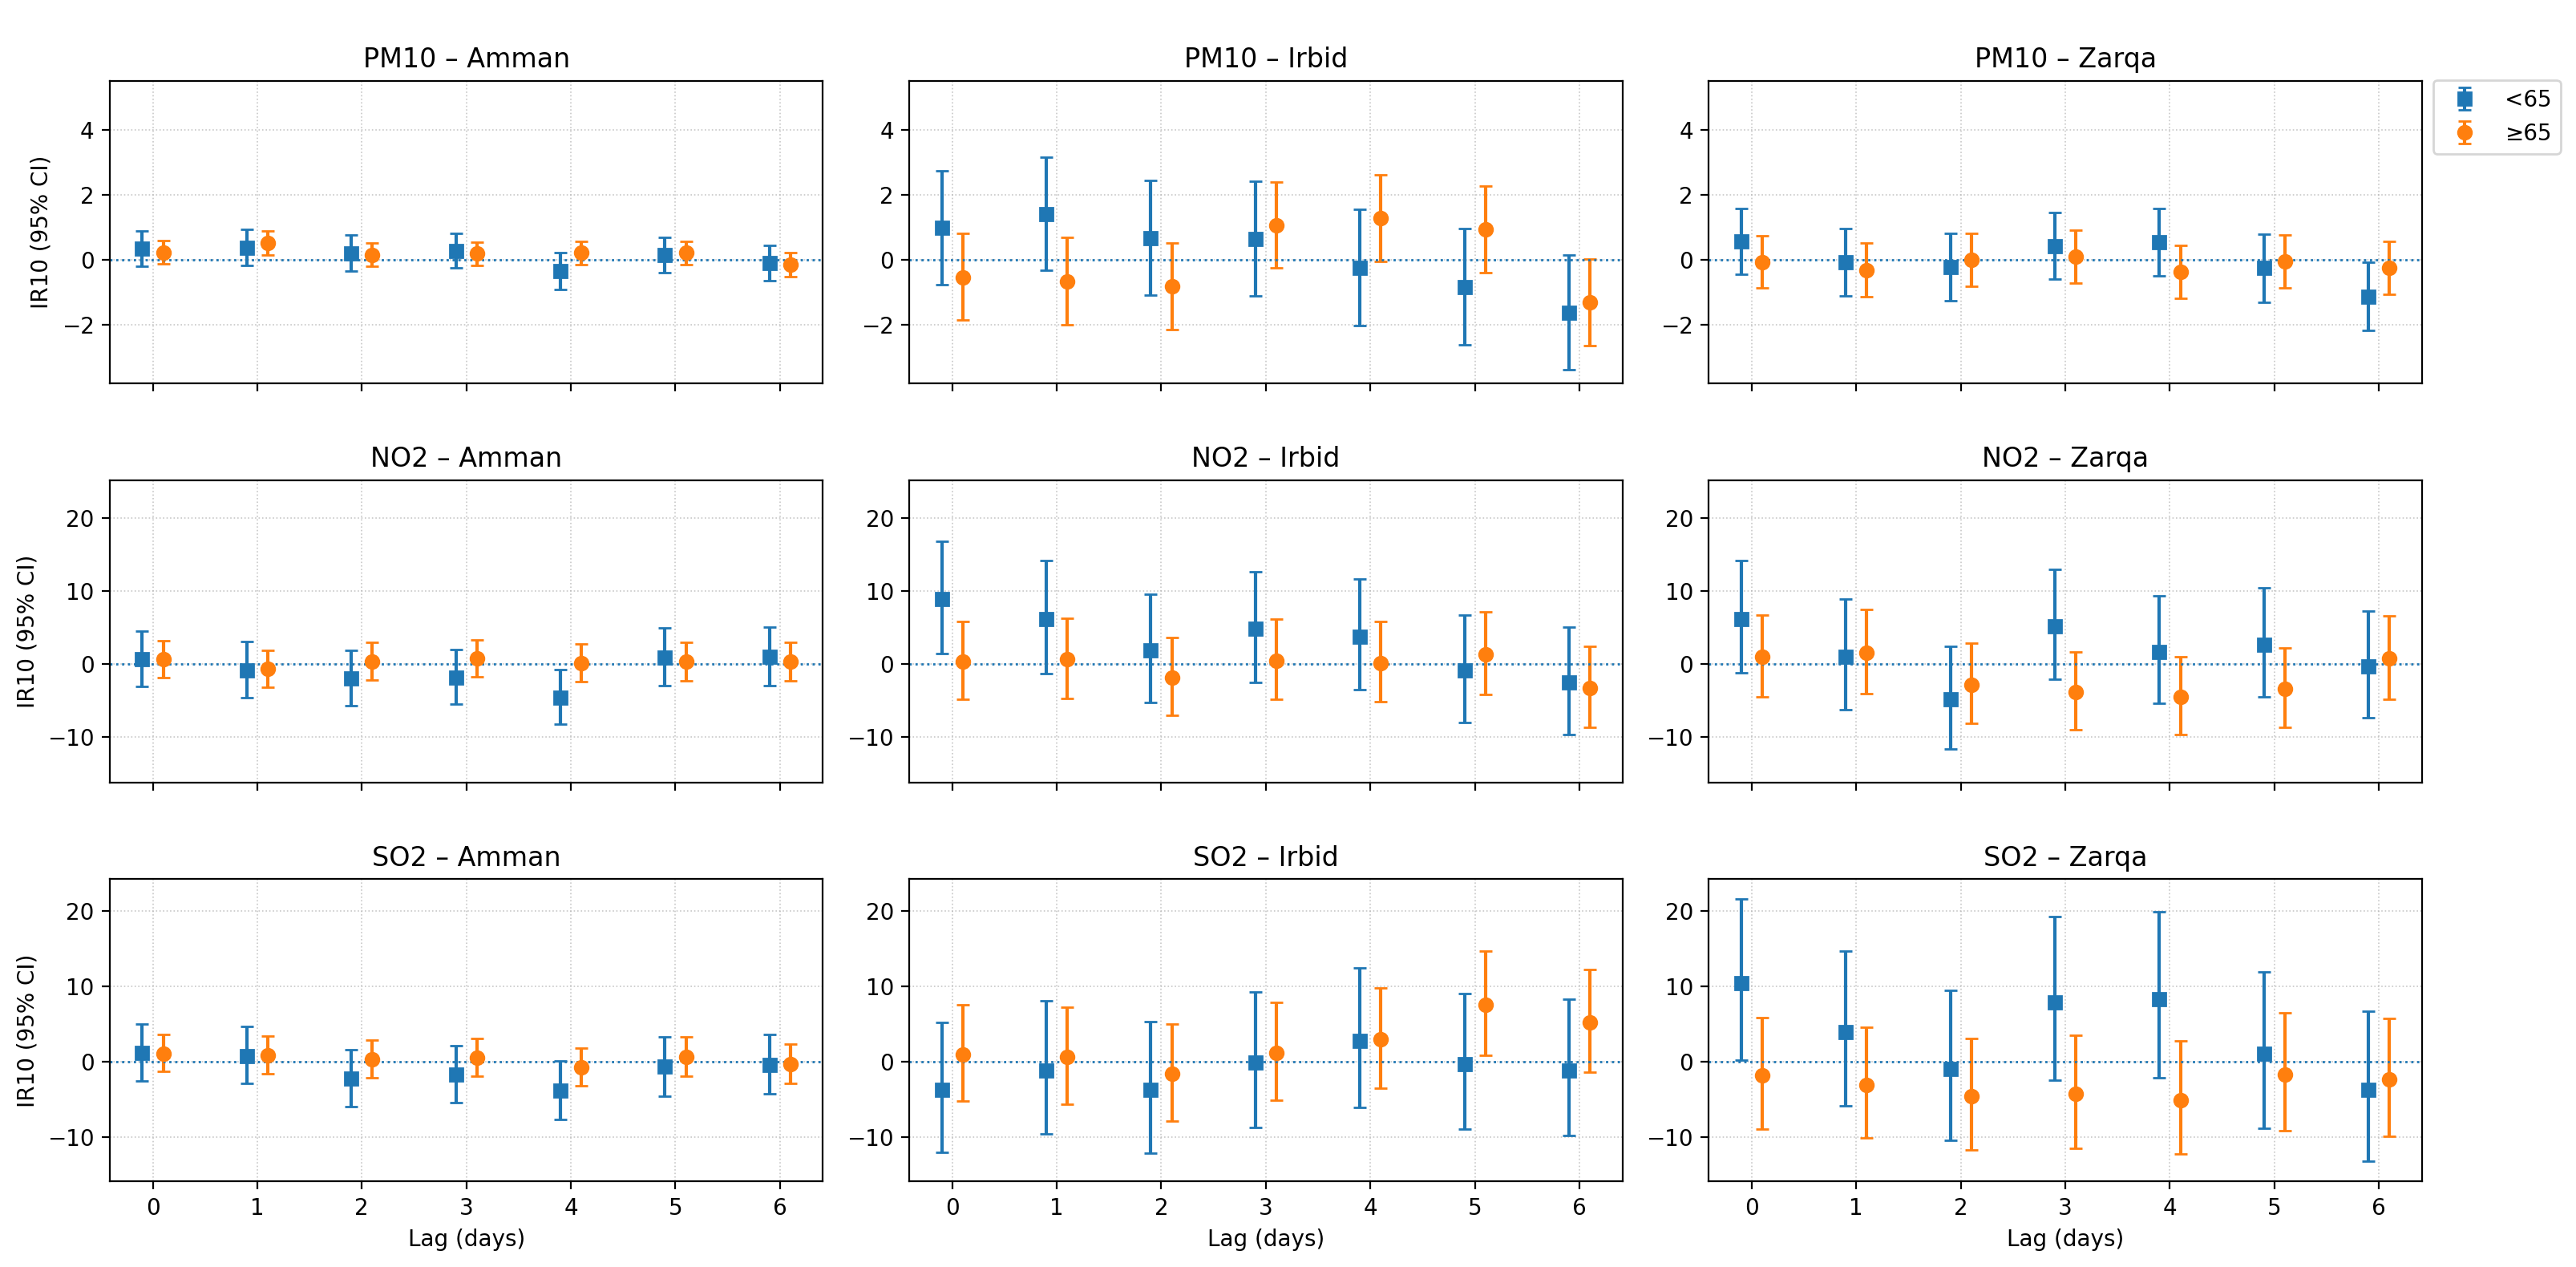

In [20]:
# Transposed 3×3 error-bar grid (rows = pollutants, cols = cities)
# - Age-stratified series: Old (>=65) vs Young (<65)
# - Center: IR10
# - 95% CI: [inf10, sup10]
# - X-axis (lags): ['0','1','2','3','4','5','6','01','25','05']
# - Each ROW (pollutant) shares the same y-axis across the three cities
# - FIX: force the last 3 points to be lags 01, 25, 05 taken from the last 3 rows (in that order)

# ---------- Config ----------
BASE_DIR = "./Age/"  # change to "." if running locally
LAGS_LABELS = ['0','1','2','3','4','5','6','01','25','05']
N = len(LAGS_LABELS)
X = np.arange(N)

# File mapping: (City, Pollutant) -> {"Old": path, "Young": path}
files_map = {
    # Amman
    ("Amman", "PM10"): {
        "Old":   os.path.join(BASE_DIR, "Amman_PM10_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Amman_PM10_Young.xlsx"),
    },
    ("Amman", "NO2"): {
        "Old":   os.path.join(BASE_DIR, "Amman_NO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Amman_NO2_Young.xlsx"),
    },
    ("Amman", "SO2"): {
        "Old":   os.path.join(BASE_DIR, "Amman_SO2_Old.xlsx"),
        # Note: provided filename has mixed case "So2"
        "Young": os.path.join(BASE_DIR, "Amman_So2_Young.xlsx"),
    },
    # Irbid
    ("Irbid", "PM10"): {
        "Old":   os.path.join(BASE_DIR, "Irbid_PM10_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Irbid_PM10_Young.xlsx"),
    },
    ("Irbid", "NO2"): {
        "Old":   os.path.join(BASE_DIR, "Irbid_NO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Irbid_NO2_Young.xlsx"),
    },
    ("Irbid", "SO2"): {
        "Old":   os.path.join(BASE_DIR, "Irbid_SO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Irbid_SO2_Young.xlsx"),
    },
    # Zarqa
    ("Zarqa", "PM10"): {
        "Old":   os.path.join(BASE_DIR, "Zarqa_PM10_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Zarqa_PM10_Young.xlsx"),
    },
    ("Zarqa", "NO2"): {
        "Old":   os.path.join(BASE_DIR, "Zarqa_NO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Zarqa_NO2_Young.xlsx"),
    },
    ("Zarqa", "SO2"): {
        "Old":   os.path.join(BASE_DIR, "Zarqa_SO2_Old.xlsx"),
        "Young": os.path.join(BASE_DIR, "Zarqa_SO2_Young.xlsx"),
    },
}

# TRANSPOSED layout:
row_order = ["PM10", "NO2", "SO2"]            # rows = pollutants
col_order = ["Amman", "Irbid", "Zarqa"]       # cols = cities

# ---------- Data loader with tail override (01,25,05) ----------
def load_ir_ci_series(path):
    """
    Expect columns: IR10, inf10, sup10.
    RULE: the last three rows in every file are the lags '01', '25', '05' in this exact order.
    We take those three points strictly from the last three rows.
    For the first 7 lags ('0'..'6'), we try to use a 'lag'/'lags' column if present;
    otherwise we take the first 7 rows as lags 0..6 in order.

    Returns
    -------
    y : (10,) array
        Center values (IR10) aligned to LAGS_LABELS.
    yerr : (2,10) array
        Asymmetric errors [lower, upper] aligned to LAGS_LABELS.
    """
    df = pd.read_excel(path).reset_index(drop=True)
    cols = {c.lower(): c for c in df.columns}

    IR = cols.get("ir10")
    LO = cols.get("inf10")
    HI = cols.get("sup10")
    if IR is None or LO is None or HI is None:
        raise ValueError(f"{os.path.basename(path)} must contain IR10, inf10, sup10 columns.")

    y = np.full(N, np.nan, dtype=float)
    yerr_low = np.full(N, np.nan, dtype=float)
    yerr_high = np.full(N, np.nan, dtype=float)

    # ----- Last three lags from the last three rows -----
    if len(df) < 3:
        raise ValueError(f"{os.path.basename(path)} has fewer than 3 rows.")
    tail = df.tail(3).reset_index(drop=True)
    tail_labels = ['01', '25', '05']
    for k, lbl in enumerate(tail_labels):
        idx = LAGS_LABELS.index(lbl)
        val = float(tail.loc[k, IR])
        lo  = float(tail.loc[k, LO])
        hi  = float(tail.loc[k, HI])
        y[idx] = val
        yerr_low[idx]  = abs(val - lo)
        yerr_high[idx] = abs(hi - val)

    # ----- First seven lags (0..6) -----
    head = df.iloc[:max(0, len(df) - 3)].copy()
    lag_col = None
    for key in ["lag", "lags", "day", "index"]:
        if key in cols:
            lag_col = cols[key]
            break

    if lag_col is not None and not head.empty:
        head["_lag_key"] = head[lag_col].astype(str).str.strip()
        for intlag in range(7):
            lbl = str(intlag)
            sel = head[head["_lag_key"] == lbl]
            if sel.empty:
                # try numeric tolerance (e.g., 0.0)
                try:
                    sel = head[np.isclose(head[lag_col].astype(float), float(intlag), equal_nan=False)]
                except Exception:
                    sel = pd.DataFrame()
            if not sel.empty:
                row = sel.iloc[0]
                idx = LAGS_LABELS.index(lbl)
                val = float(row[IR]); lo = float(row[LO]); hi = float(row[HI])
                y[idx] = val
                yerr_low[idx]  = abs(val - lo)
                yerr_high[idx] = abs(hi - val)
    else:
        # No lag column: assume the first 7 rows correspond to 0..6
        if len(head) < 7:
            head = pd.concat([head, pd.DataFrame([{IR: np.nan, LO: np.nan, HI: np.nan}] * (7 - len(head)))],
                             ignore_index=True)
        for intlag in range(7):
            row = head.iloc[intlag]
            idx = LAGS_LABELS.index(str(intlag))
            val = float(row[IR]) if pd.notna(row[IR]) else np.nan
            lo  = float(row[LO]) if pd.notna(row[LO]) else np.nan
            hi  = float(row[HI]) if pd.notna(row[HI]) else np.nan
            y[idx] = val
            yerr_low[idx]  = abs(val - lo) if np.all(pd.notna([val, lo])) else np.nan
            yerr_high[idx] = abs(hi - val) if np.all(pd.notna([val, hi])) else np.nan

    return y, np.vstack([yerr_low, yerr_high])

# ---------- Compute row-wise (pollutant-wise) y-limits ----------
def compute_row_ylim(pollutant):
    ymin, ymax = np.inf, -np.inf
    for city in col_order:
        pair = files_map[(city, pollutant)]
        for grp in ("Old", "Young"):
            y, yerr = load_ir_ci_series(pair[grp])
            lo = y - yerr[0]
            hi = y + yerr[1]
            if np.isfinite(np.nanmin(lo)):
                ymin = min(ymin, np.nanmin(lo))
            if np.isfinite(np.nanmax(hi)):
                ymax = max(ymax, np.nanmax(hi))
    if not np.isfinite(ymin) or not np.isfinite(ymax) or ymin == ymax:
        ymin, ymax = 0.9, 1.1
    pad = 0.05 * (ymax - ymin)
    return ymin - pad, ymax + pad

row_ylim = {poll: compute_row_ylim(poll) for poll in row_order}

# ---------- Plot (transposed: rows = pollutants; columns = cities) ----------
fig, axes = plt.subplots(3, 3, figsize=(16, 8), constrained_layout=True, sharex=True, dpi=200)

for i, pollutant in enumerate(row_order):
    for j, city in enumerate(col_order):
        ax = axes[i, j]
        pair = files_map[(city, pollutant)]

        

        # Young (<65)
        y_yng, yerr_yng = load_ir_ci_series(pair["Young"])
        ax.errorbar(X[:7] - 0.1, y_yng[:7], yerr=yerr_yng[:,:7], fmt='s', capsize=3, label='<65')
        # Old (>=65)
        y_old, yerr_old = load_ir_ci_series(pair["Old"])
        ax.errorbar(X[:7] + 0.1, y_old[:7], yerr=yerr_old[:,:7], fmt='o', capsize=3, label='≥65')
        
        # Titles & axes
        ax.set_title('\n' + f"{pollutant} – {city}")
        ax.set_xticks(X[:7])
        ax.set_xticklabels(LAGS_LABELS[:7])
        if j == 0:
            ax.set_ylabel("IR10 (95% CI)")
        if i == len(row_order) - 1:
            ax.set_xlabel("Lag (days)")

        # Row-wise y-axis (same for given pollutant across all cities)
        ax.set_ylim(row_ylim[pollutant])

        # Reference line at RR=1
        ax.axhline(0, linestyle=":", linewidth=1)

        # Grid and legend
        ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
        if i == 0 and j == 2:
            ax.legend(bbox_to_anchor=(-1.79, -1.96, 3, 3))

#plt.suptitle("IR10 with 95% CI by Pollutant (rows) and City (columns) — Old vs Young", y=1.02, fontsize=14)
#plt.savefig("errorbars_3x3_transposed_age.png", dpi=300)
plt.tight_layout()
plt.show()
